In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import pandas as pd
from numba import njit, jit
from numba.typed import Dict, List
from sklearn.metrics._classification import accuracy_score, balanced_accuracy_score
from sklearn.metrics import auc, roc_curve, roc_auc_score

In [15]:
dataset = np.load("japan.npz")
x_train = dataset["x_train"]
x_test = dataset["x_test"]
y_train = dataset["y_train"]
y_test = dataset["y_test"]

In [16]:
x_train[:,:,:,:2] *= 6371*2*np.pi/180
x_test[:,:,:,:2] *= 6371*2*np.pi/180

In [17]:
class MaskedConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None, eps=1e-10) -> None:
        super().__init__()
        self.eps = eps
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, 
                              stride=stride, padding=padding, dilation=dilation, 
                              groups=groups, bias=bias, padding_mode=padding_mode, 
                              device=device, dtype=dtype)
        self.gamma = nn.Parameter(torch.ones((1, out_channels, 1, 1), requires_grad=True, device=device))
        self.beta = nn.Parameter(torch.zeros((1, out_channels, 1, 1), requires_grad=True, device=device))
    def forward(self, x):
        x_mean = torch.nanmean(x, dim=(-2, -1), keepdim=True)
        x_std = ((x - x_mean).square().nanmean(dim=(-2,-1), keepdim=True)+self.eps).sqrt()
        x = (x-x_mean)/x_std
        return self.gamma*self.conv(x)+self.beta


# Single Cell

In [18]:
Nlat = y_train.shape[1]
Nlon = y_train.shape[2]
good_cells_train = np.argwhere(np.isfinite(x_train).all(axis=-1)) #(N_train, 3) indices
good_cells_test= np.argwhere(np.isfinite(x_test).all(axis=-1)) #(N_test, 3) indices

In [19]:
df_train = pd.DataFrame()
df_train['sample'] = good_cells_train[:,0] 
df_train['lat'] = good_cells_train[:,1] 
df_train['lon'] = good_cells_train[:,2] 
df_train['label'] = y_train[good_cells_train[:,0] , good_cells_train[:,1] , good_cells_train[:,2] ] # y, aftershocks map
df_train['u_n'] = x_train[good_cells_train[:,0] , good_cells_train[:,1] , good_cells_train[:,2], 0]
df_train['u_e'] = x_train[good_cells_train[:,0] , good_cells_train[:,1] , good_cells_train[:,2], 1]
df_train['u_v'] = x_train[good_cells_train[:,0] , good_cells_train[:,1] , good_cells_train[:,2], 2]

In [20]:
df_test = pd.DataFrame()
df_test['sample'] = good_cells_test[:,0] 
df_test['lat'] = good_cells_test[:,1] 
df_test['lon'] = good_cells_test[:,2] 
df_test['label'] = y_train[good_cells_test[:,0] , good_cells_test[:,1] , good_cells_test[:,2] ]
df_test['u_n'] = x_test[good_cells_test[:,0] , good_cells_test[:,1] , good_cells_test[:,2], 0]
df_test['u_e'] = x_test[good_cells_test[:,0] , good_cells_test[:,1] , good_cells_test[:,2], 1]
df_test['u_v'] = x_test[good_cells_test[:,0] , good_cells_test[:,1] , good_cells_test[:,2], 2]

In [25]:
lr_global = LogisticRegression(C=0.01, random_state=0,class_weight='balanced')
lr_global.fit(df_train[['u_n', 'u_e', 'u_v']].values, np.heaviside(df_train['label'].values, 0))

LogisticRegression(C=0.01, class_weight='balanced', random_state=0)

In [26]:
fpr, tpr, thresholds = roc_curve(np.heaviside(df_test['label'].values, 0),lr_global.predict_proba(df_test[['u_n', 'u_e', 'u_v']].values)[:,1] )

In [35]:
coefs = np.ones((Nlat, Nlon, 3))*np.nan
intercept = np.ones((Nlat, Nlon))*np.nan
lrs = {}
for cell,group in df_train.groupby(["lat","lon"]):
    x_c = group[['u_n', 'u_e', 'u_v']].values
    y_c = np.heaviside(group['label'].values, 0)
    w1 = y_c.sum()
    if(w1>5):
        lr = LogisticRegression(C=1, random_state=0,class_weight='balanced')
        lr.fit(x_c, y_c)
        coefs[cell[0], cell[1], :] = lr.coef_
        intercept[cell[0], cell[1]] = lr.intercept_
        lrs[(cell[0], cell[1])] = lr

In [36]:
scores = np.ones((Nlat, Nlon))*np.nan
for cell,group in df_test.groupby(["lat","lon"]):
    x_c = group[['u_n', 'u_e', 'u_v']].values
    y_c = np.heaviside(group['label'].values, 0)
    if (cell[0], cell[1]) in lrs and y_c.sum()>0:
        lr= lrs[ (cell[0], cell[1])]
        y_c_pred = lr.predict(x_c)
        scores[cell[0], cell[1]] = balanced_accuracy_score(y_c, y_c_pred)

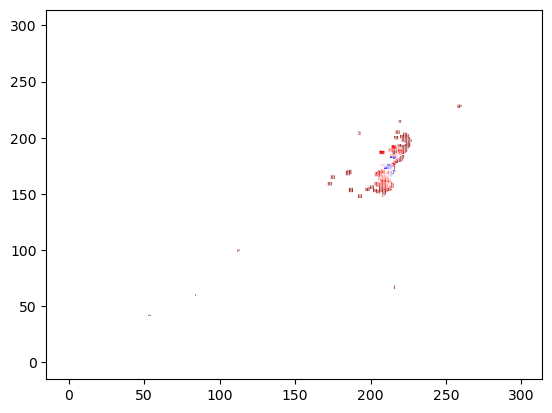

In [37]:
plt.quiver(coefs[:,:,1], coefs[:,:,0], intercept, cmap='seismic')

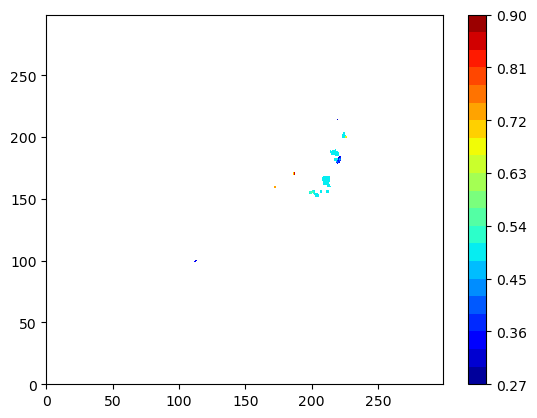

In [41]:
plt.contourf(scores, levels=20, cmap='jet')
plt.colorbar()